The model has 8,241,302 trainable parameters
Epoch 1: training loss 0.589605987071991, validation loss 0.6354731917381287, memory usage 154 MB.
Epoch 2: training loss 0.5716159343719482, validation loss 0.629721462726593, memory usage 154 MB.
Epoch 3: training loss 0.5643696784973145, validation loss 0.6154801845550537, memory usage 154 MB.
Epoch 4: training loss 0.5566169619560242, validation loss 0.6003367304801941, memory usage 154 MB.
Epoch 5: training loss 0.550459086894989, validation loss 0.5873132348060608, memory usage 154 MB.
Epoch 6: training loss 0.547076404094696, validation loss 0.5782495141029358, memory usage 154 MB.
Epoch 7: training loss 0.5434396266937256, validation loss 0.5721898674964905, memory usage 154 MB.
Epoch 8: training loss 0.5400393009185791, validation loss 0.5682768225669861, memory usage 154 MB.
Epoch 9: training loss 0.5372921824455261, validation loss 0.5656715631484985, memory usage 154 MB.
Epoch 10: training loss 0.5333930253982544, validation loss

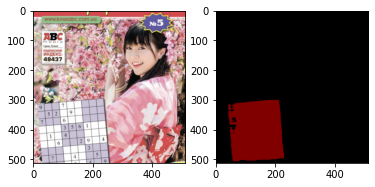

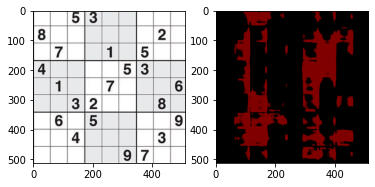

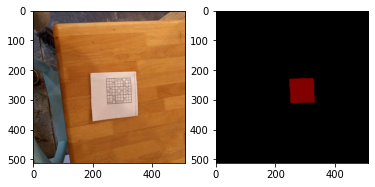

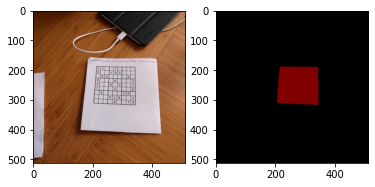

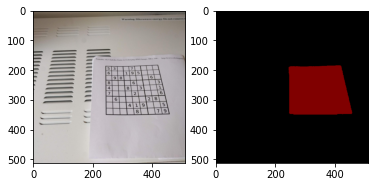

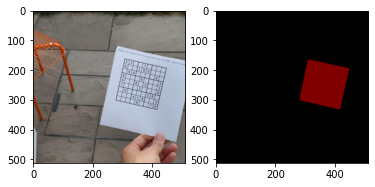

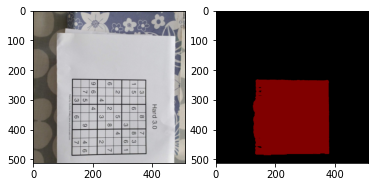

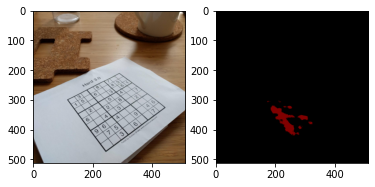

In [ ]:
import torch 
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, sampler

from matplotlib import pyplot
from PIL import Image
import numpy as np
from pathlib import Path

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 3, 1)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)
        self.conv5 = self.contract_block(256, 512, 3, 1)

        self.drop = torch.nn.Dropout2d(p=0.25)
        self.upconv5 = self.expand_block(512, 256, 3, 1)

        self.upconv4 = self.expand_block(256*2, 128, 3, 1)

        self.upconv3 = self.expand_block(128*2, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def forward(self, batch):

        # downsampling part
        conv1 = self.conv1(batch)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        drop = self.drop(conv5)
        
        upconv5 = self.upconv5(drop)
        upconv4 = self.upconv4 (torch.cat([upconv5, conv4], 1))

        upconv3 = self.upconv3 (torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2 (torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            #torch.nn.Dropout2d(p=0.25)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                            #torch.nn.Dropout2d(p=0.25)
                            )
        return expand

model = UNET(3, 2) #3 colour channels, binary output

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
        # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
        (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
        # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
        (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
        # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
        (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
        # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
        (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

preprocess = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
])

preprocess2 = transforms.Compose([
    transforms.ToTensor()
])

def test_single(filename):
    with torch.no_grad():
        image = Image.open(filename)

        image = preprocess(image)
        input_tensor = preprocess2(image)
        
        input_batch = input_tensor.unsqueeze(0).to(device) # create a mini-batch as expected by the model

        out = model(input_batch)
        om = torch.argmax(out.squeeze(), dim=0).cpu()
        rgb = decode_segmap(om)
        pyplot.subplot(121),pyplot.imshow(image)
        pyplot.subplot(122),pyplot.imshow(rgb)
        pyplot.show()

loss_func = F.cross_entropy

batch_size = 11
learning_rate = 0.0005
num_epochs = 100

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

class SegDataset(Dataset):
    def __init__(self, image_dir, label_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, image_dir, label_dir) for f in image_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, image_file: Path, image_dir, label_dir):
        
        files = {'image': image_file, 
                 'label': label_dir/image_file.name.replace('Image', 'Label').replace('jpg', 'png')}
        return files
                                       
    def __len__(self):
        return len(self.files)

    def open_as_array(self, idx, invert=False):
        img = Image.open(self.files[idx]['image'])
        img = preprocess(img)
        raw_rgb = np.array(img)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)

    def open_mask(self, idx, add_dims=False):
        img = Image.open(self.files[idx]['label'])
        img = preprocess(img)
        raw_mask = np.array(img)
        #raw_mask = np.where(raw_mask==1, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def __getitem__(self, idx):
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        arr = 256*self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s
                
path = Path ('./drive/My Drive/sudata')
train_data = SegDataset(path/'images', path/'labels')

train_ds, valid_ds = torch.utils.data.random_split(train_data, (33, 11))
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3)
valid_dataloader = DataLoader(valid_ds, batch_size=11)

best_valid_loss = float('inf')
train_loss = float('inf')
valid_loss = float('inf')
epoch = 0
#for epoch in range(num_epochs):
while (train_loss > 0.1 or valid_loss > 0.1):
    model.train()
    train_loss = 0
    epoch += 1
    #print(f'Epoch {epoch}')
    for x_batch,y_batch in train_dataloader:
        predictions = model(x_batch.to(device))
        loss = loss_func(predictions, y_batch.to(device))
        train_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(x_batch.to(device)), y_batch.to(device)) for x_batch, y_batch in valid_dataloader)
        train_loss = train_loss / len(train_dataloader)
        valid_loss = valid_loss / len(valid_dataloader)
        print(f'Epoch {epoch}: training loss {train_loss}, validation loss {valid_loss}, memory usage {int (torch.cuda.memory_allocated()/1024/1024)} MB.')
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path/'doku.pt')
        '''
        else:
          epoch -= 1
	        print ('Unsuccessful epoch, discarding...')
	        model.load_state_dict(torch.load('doku.pt'))
          '''

torch.save(model.state_dict(), path/'doku.pt')
	
test_single(path/"981.png")
test_single(path/"395.png")
test_single(path/"Image_45.jpg")
test_single(path/"Image_46.jpg")
test_single(path/"Image_47.jpg")
test_single(path/"Image_48.jpg")
test_single(path/"Image_49.jpg")
test_single(path/"Image_50.jpg")
